In [1]:
import pandas as pd
from langchain.schema import Document

file2 = "/home/Preda/user/Sony_InternProj/data/20240918/マニュアルQA(最終RAG).xlsx"
df2 = pd.read_excel(file2)

def convert_to_documents(cell):
    # 检查是否为标量值（字符串、整数、浮点数）
    if isinstance(cell, (str, int, float)):
        if pd.isna(cell):
            return None  # 如果是 NaN，直接返回 None
    else:
        if cell is None:
            return None

    try:
        # 如果 cell 已经是 Document 对象，直接返回
        if isinstance(cell, Document):
            return [cell]  # 转换成列表形式

        # 如果 cell 是字符串，尝试使用 eval 进行转换
        if isinstance(cell, str):
            documents_data = eval(cell)

            # 如果是包含 Document 对象的列表，直接返回整个列表
            if isinstance(documents_data, list) and all(isinstance(item, Document) for item in documents_data):
                return documents_data  # 返回整个 Document 列表
            # 如果是单个 Document 对象，返回一个包含它的列表
            elif isinstance(documents_data, Document):
                return [documents_data]
            else:
                return None
        else:
            return None
    except Exception as e:
        # 打印异常信息并返回 None
        print(f"Error parsing cell: {e}")
        return None

df2["関連情報"] = df2["関連情報"].apply(convert_to_documents)
df2["source_path"] = df2.apply(lambda row: [sp.metadata["source_path"] for sp in row["関連情報"]], axis=1)

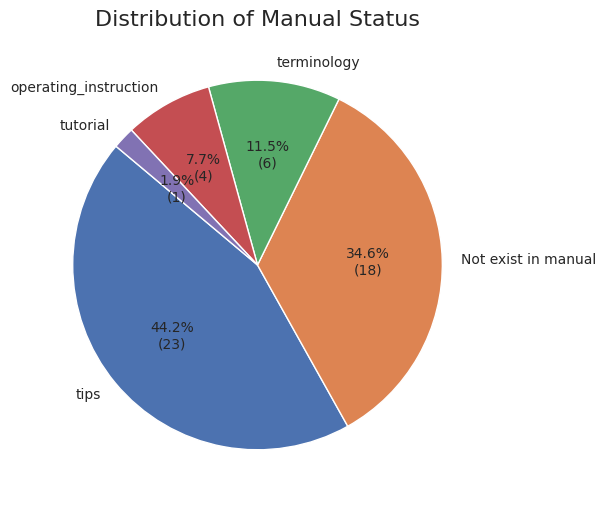

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

def classify(value):
    if pd.isna(value) or value == "NaN":
        return "Not exist in manual"
    else:
        return value.split("/")[0]

df2["Manual_Status"] = df2["マニュアル該当箇所"].apply(classify)
status_counts = df2["Manual_Status"].value_counts()
labels_with_counts = [f'{label} ({count})' for label, count in zip(status_counts.index, status_counts.values)]


plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(
    status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140, 
    textprops={'fontsize': 10}
)

# Add counts directly below percentages
for i, autotext in enumerate(autotexts):
    count = status_counts.values[i]
    autotext.set_text(f'{autotext.get_text()}\n({count})')  # Adding count on a new line

# Set title
plt.title('Distribution of Manual Status', fontsize=16)

plt.show()

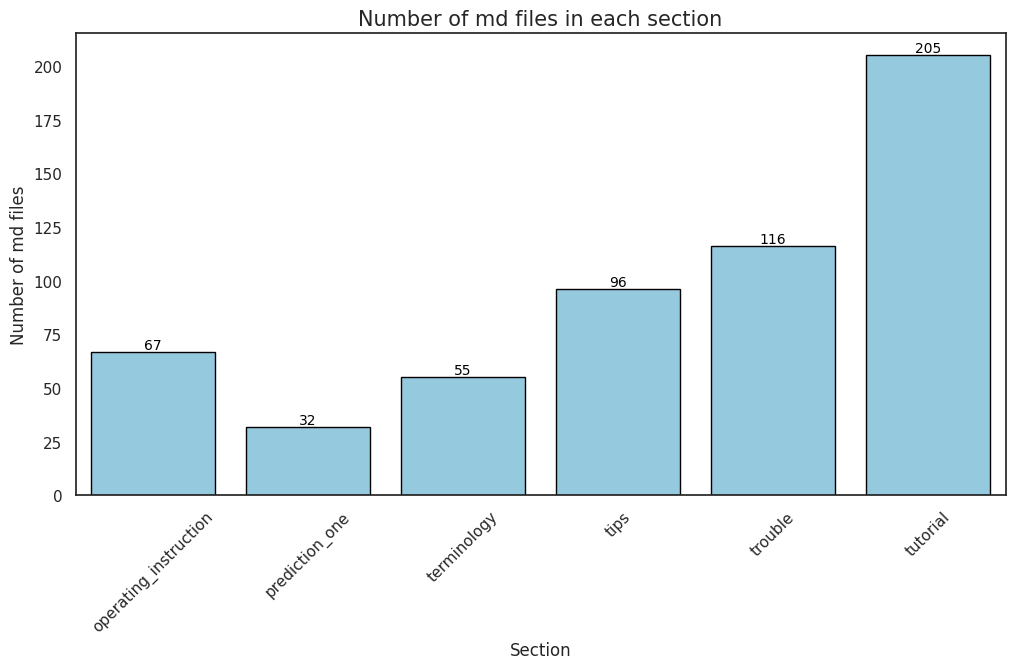

In [44]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

def extract_path(file):
    # content directory
    parts = file.split("content/")
    if len(parts)>1:
        relevant_path = parts[1]
        relevant_path = os.path.dirname(relevant_path)
        return relevant_path
    

def count_jp_md_files(root_dir):
    counts = {
        "operating_instruction": 0,
        "prediction_one": 0,
        "terminology": 0,
        "tips": 0,
        "trouble": 0,
        "tutorial": 0,
    }
    for dir_path, _,files in os.walk(root_dir):
        for file in files:
            if file.endswith(".jp.md"):
                relevant_path = extract_path(dir_path)
                for key in counts.keys():
                    if relevant_path.startswith(key):
                        counts[key] += 1
    return counts

root_dir = "/home/Preda/user/Sony_InternProj/content"
counts = count_jp_md_files(root_dir)

def plot_md_file_counts_skyblue_with_labels_no_grid(counts):
    # Set the style to match the desired aesthetics without grid
    sns.set(style="white")

    # Create the figure with specified size
    plt.figure(figsize=(12, 6))
    
    # Plotting the bar chart with seaborn styling and skyblue color
    bars = sns.barplot(x=list(counts.keys()), y=list(counts.values()), color='skyblue', edgecolor='black')
    
    # Add text labels on each bar
    for bar in bars.containers[0]:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, int(height), ha='center', va='bottom', fontsize=10, color='black')
    
    # Set labels and title
    plt.xlabel('Section', fontsize=12)
    plt.ylabel('Number of md files', fontsize=12)
    plt.title('Number of md files in each section', fontsize=15)
    
    # Remove grid lines
    plt.grid(False)
    
    # Rotate x-ticks for better visibility
    plt.xticks(rotation=45)
    
    # Display the plot
    plt.show()

# Plot the counts using skyblue color, add labels, and remove grid
plot_md_file_counts_skyblue_with_labels_no_grid(counts)



In [2]:
import os
import re
import glob
import yaml
from typing import List
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter

def find_jp_md_files(root_dir):
    # find all jp.md files in the root_dir
    jp_md_files = []
    for dir_path, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.jp.md'):
                full_path = os.path.join(dir_path, file)
                jp_md_files.append(full_path)
    return jp_md_files

def extract_path(file):
    # content directory
    parts = file.split("content/")
    if len(parts)>1:
        relevant_path = parts[1]
        relevant_path = os.path.dirname(relevant_path)
        return relevant_path

def process_md_files(jp_md_files: List[str]) -> List[Document]:
    # Read all jp.md files and extract metadata, content
    all_chunks = []
    for file_path in jp_md_files:
        with open(file_path, 'r') as f:
            md_content = f.read()
        parts = md_content.split('---', 2)
        if len(parts) < 3:
            print(f"Error: {file_path} has missing info")
            continue
        try:
            metadata = yaml.safe_load(parts[1].strip("\n"))
        except yaml.YAMLError:
            print(f"Error: Unable to parse YAML in {file_path}")
            continue
        content = parts[2].strip("\n")
        source_path = extract_path(file_path)
        doc = Document(
            page_content = content,
            metadata = { 
                "title": metadata.get("title", "").strip(""),
                "description": metadata.get("meta", {}).get("description", "").strip(""),
                "keywords": metadata.get("keywords", []),
                "source_path": source_path,
            }
        )
        all_chunks.append(doc)
    return all_chunks
            
def clean_html(text: str) -> str:
    # clean html tags, markdown tags, and other special characters
    text = re.sub(r'{{[<%]?\s*/?dist_type_exclude\s*(?:"[^"]*")?\s*[%>]?}}', ' ', text)
    text = re.sub(r'{{% /desktop_only %}}', ' ', text)
    text = re.sub(r'{{<\s*ref\s+"([^"]+)"\s*>}}([^)]+)', r'\1\2', text)
    text = re.sub(r'{{% a_in\s+"([^"]+)"\s+"([^"]+)"(?:\s+"[^"]*")?\s+%}}', r' [\2](\1)', text)
    text = re.sub(r'{{% step_n\s+\d+\s+"([^"]+)"\s+%}}', r'\1', text)
    text = re.sub(r'<a[^>]*>(.*?)', r'\1', text)
    text = re.sub(r'<img[^>]*src="([^"]*)"[^>]*>', r'![](\1)', text)
    text = re.sub(r'{{% dist_type_only\s+"[^"]+"\s+%}}', ' ', text)
    text = re.sub(r'{{% /dist_type_only %}}', ' ', text)
    text = re.sub(r'{{% notice\s+tip\s+"([^"]+)"\s+"([^"]+)"\s+%}}', r'[Tip: \2](\1)', text)
    text = re.sub(r'{{% /notice %}}', ' ', text)
    text = re.sub(r'{{% desktop_only %}}(.*?){{% /desktop_only %}}', r'[Desktop Only] \1', text, flags=re.DOTALL)
    text = re.sub(r'{{% cloud_only %}}(.*?){{% /cloud_only %}}', r'[Cloud Only] \1', text, flags=re.DOTALL)

    tags_to_remove = [
        r'<tr[^>]*>', r'</tr>',
        r'<td[^>]*>', r'</td>',  
        r'<p[^>]*>', r'</p>',
        r'</a>', r'<a[^>]*>',
        r'<table[^>]*>', r'</table>',
        r'<b[^>]*>', r'</b>',
        r'<br\s*/?>', 
        r'<style[^>]*>.*?</style>',
        r'<details[^>]*>', r'</details>',
        r'<div[^>]*>', r'</div>',
    ]
    for tag in tags_to_remove:
        text = re.sub(tag, ' ', text, flags=re.DOTALL)
    
    patterns = [
        r'{{[<%]?\s*/?dist_type_exclude\s*(?:"[^"]*")?\s*[%>]?}}',
        r'{{<\s*youtube\s+[^>]*>}}', 
        r'{{[<%][^}]*[%>]}}',  
    ]
    for pattern in patterns:
        text = re.sub(pattern, ' ', text)
    
    text = re.sub(r'\*\*([^*]+)\*\*', r'\1', text)
    text = re.sub(r'^-\s*', '- ', text, flags=re.MULTILINE)
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def chunk_md_files(all_chunks: List[Document]) -> List[Document]:
    # Split the content into chunks
    new_chunks = []
    for doc in all_chunks:
        headers_to_split = [
            ("#", "Subtitle"),
            ("##", "Subtitle"),
            ("###", "Subtitle"),
            ("####", "Subtitle"),
            ("#####", "Subtitle"),
            ("######", "Subtitle"),
        ]
        markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split)
        splits = markdown_splitter.split_text(doc.page_content)
        chunk_id = 0
        for split in splits:
            new_chunk = Document(
                metadata = {**doc.metadata, **split.metadata, "chunk_id": chunk_id},
                page_content = clean_html(split.page_content),
            )
            new_chunks.append(new_chunk)
            chunk_id += 1
    return new_chunks

root_dir = "/home/Preda/user/Sony_InternProj/content"
vector_db_path = "/home/Preda/user/Sony_InternProj/data/vectordb"
file_path = "/home/Preda/user/Sony_InternProj/data/20240918/マニュアルQA正解データ.xlsx"

jp_md_files = find_jp_md_files(root_dir)
all_chunks = process_md_files(jp_md_files)
all_chunks = chunk_md_files(all_chunks)

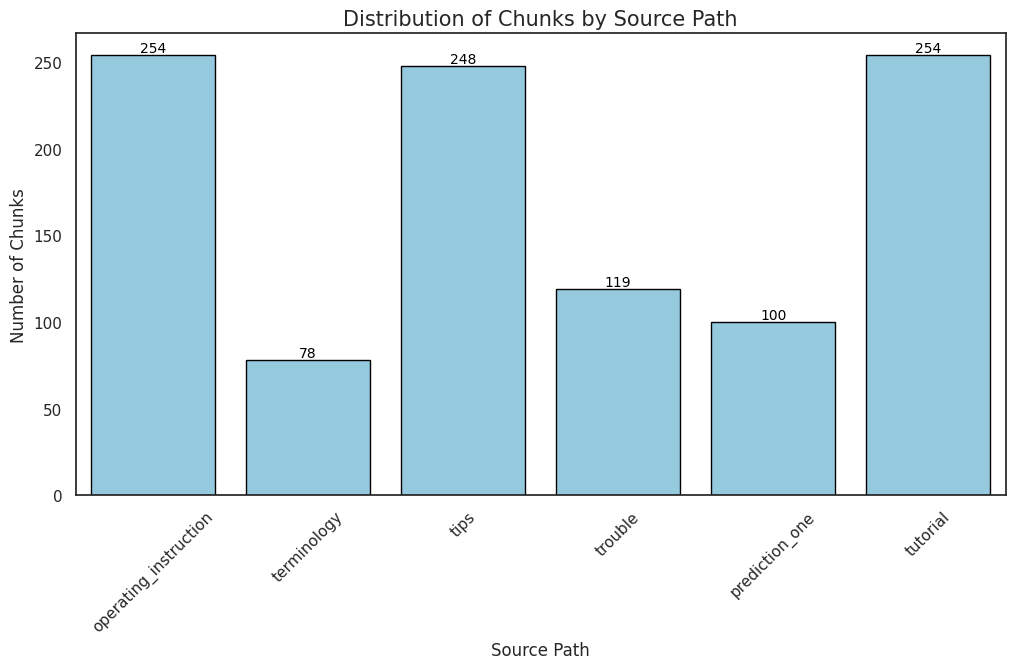

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
# Assuming 'all_chunks' is defined, proceed with the plotting function

def plot_chunk_source_path_distribution_no_grid(all_chunks):
    # Extract the first part of the source_path for each chunk
    source_paths = [chunk.metadata['source_path'].split('/')[0] for chunk in all_chunks]
    
    # Count the occurrences of each source_path
    source_path_counts = Counter(source_paths)
    
    # Convert the counts to lists for plotting
    labels, counts = zip(*source_path_counts.items())

    # Set the style for the plot without grid
    sns.set(style="white")

    # Create a figure for the histogram
    plt.figure(figsize=(12, 6))

    # Plot the histogram using skyblue color
    bars = sns.barplot(x=list(labels), y=list(counts), color='skyblue', edgecolor='black')

    # Add text labels on each bar
    for bar in bars.containers[0]:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, int(height), ha='center', va='bottom', fontsize=10, color='black')

    # Add labels and title
    plt.xlabel('Source Path', fontsize=12)
    plt.ylabel('Number of Chunks', fontsize=12)
    plt.title('Distribution of Chunks by Source Path', fontsize=15)

    # Rotate x-ticks for better readability
    plt.xticks(rotation=45)

    # Remove grid lines
    plt.grid(False)

    # Display the plot
    plt.show()

# Plot the distribution using the provided all_chunks
plot_chunk_source_path_distribution_no_grid(all_chunks)



In [32]:
from typing import List

def compare_average_char_count(jp_md_files: List[str]) -> None:
    # Store original and cleaned character counts
    original_counts = []
    cleaned_counts = []

    for file_path in jp_md_files:
        # Read the original content
        with open(file_path, 'r') as f:
            original_content = f.read()
        
        # Clean the content
        cleaned_content = clean_html(original_content)
        
        # Store character counts
        original_counts.append(len(original_content))
        cleaned_counts.append(len(cleaned_content))

    # Calculate average character counts
    avg_original_count = sum(original_counts) / len(original_counts)
    avg_cleaned_count = sum(cleaned_counts) / len(cleaned_counts)

    # Print results
    print(f"Average character count before cleaning: {avg_original_count:.2f}")
    print(f"Average character count after cleaning: {avg_cleaned_count:.2f}")

# Run the comparison
compare_average_char_count(jp_md_files)

Average character count before cleaning: 1366.20
Average character count after cleaning: 1085.26


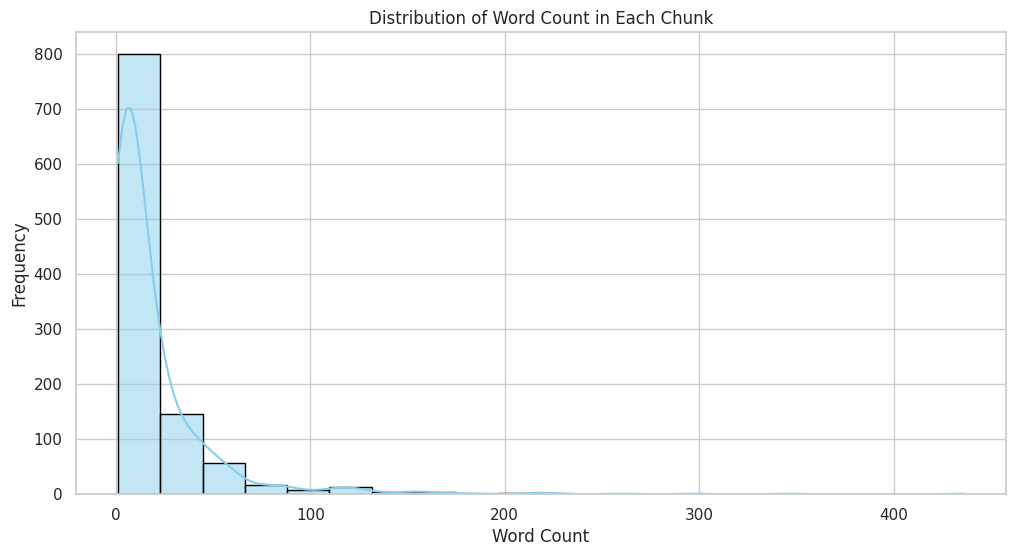

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 all_chunks 是一个包含多个 chunk 的列表
# 每个 chunk 是一个字典，包含键 'page_content'
# all_chunks = [{'page_content': '...'}, ...]

# 计算每个 chunk 中 'page_content' 的字数
word_counts = [len(chunk.page_content.split()) for chunk in all_chunks]

# 设置图形风格
sns.set(style="whitegrid")

# 创建一个图形和子图
plt.figure(figsize=(12, 6))

# 直方图和 KDE 图的组合
sns.histplot(word_counts, kde=True, color='skyblue', bins=20, edgecolor='black')

# 添加标题和标签
plt.title('Distribution of Word Count in Each Chunk')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# 显示图形
plt.show()


In [8]:
def calculate_precision_recall(df, all_chunks):
    # Initialize precision@k, recall@k, and count columns
    df["DocumentCount"] = 0
    df["Precision@k"] = 0.0
    df["Recall@k"] = 0.0

    for index, row in df.iterrows():
        retrieved_docs = row["関連情報"]

        # 检查 retrieved_docs 是否为列表并且不为空
        if not isinstance(retrieved_docs, list) or len(retrieved_docs) == 0:
            continue

        # 计数検索結果中的 Document 数量
        doc_count = len(retrieved_docs)
        df.at[index, "DocumentCount"] = doc_count

        # 检查 "マニュアル該当箇所" 是否为字符串
        if not isinstance(row["マニュアル該当箇所"], str):
            continue

        # 计算全局相关文档总数
        relevant_docs_total = sum(
            1 for chunk in all_chunks if chunk.metadata["source_path"] in row["マニュアル該当箇所"].split("\n")
        )
        print(f"Row {index}: Relevant docs total: {relevant_docs_total}")  # 调试输出
        if relevant_docs_total == 0:
            continue

        relevant_count_in_retrieved = 0
        for document_obj in retrieved_docs:
            # 直接使用 Document 对象
            if isinstance(document_obj, Document):
                print(f"Document source_path: {document_obj.metadata['source_path']}")  # 调试输出
                if document_obj.metadata["source_path"] in row["マニュアル該当箇所"].split("\n"):
                    relevant_count_in_retrieved += 1

        # 计算 Precision@k 和 Recall@k
        precision = relevant_count_in_retrieved / doc_count if doc_count > 0 else 0
        recall = relevant_count_in_retrieved / relevant_docs_total if relevant_docs_total > 0 else 0

        # 更新 DataFrame
        df.at[index, "Precision@k"] = precision
        df.at[index, "Recall@k"] = recall

    return df

df2 = calculate_precision_recall(df2, all_chunks)

Row 0: Relevant docs total: 3
Document source_path: terminology/corr
Document source_path: tips/new_features/score
Document source_path: terminology/r2
Document source_path: terminology/corr
Document source_path: terminology/corr
Document source_path: tips/advice/advice_19102
Document source_path: terminology/regression
Document source_path: tips/advice/advice_20504
Document source_path: tips/advice/advice_19103
Row 1: Relevant docs total: 20
Document source_path: tips/new_features/contribution_csv
Document source_path: tips/new_features/contribution_csv
Document source_path: tips/new_features/contribution_csv
Document source_path: operating_instruction/result/importance
Document source_path: tips/new_features/contribution_csv
Document source_path: tips/new_features/contribution_csv
Document source_path: tips/new_features/create_slide
Document source_path: tips/new_features/contribution_csv
Document source_path: tips/new_features/create_slide
Document source_path: tips/new_features/cre

In [9]:
df2[df2["マニュアル該当箇所"].notna()]

,QA番号,担当,質問カテゴリ,質問,答え（マニュアルのみ参照）,答え（マニュアル+一般知識）,マニュアル該当箇所,参考,仮想質問,関連情報,関連確認,単純にRAGの答えを参考にする,専門用語,マニュアルに説明されていない専門用語,最終回答,source_path,DocumentCount,Precision@k,Recall@k
0,NaN,山本,NaN,予測したい項目との関連度や相関係数とは何ですか？,関連度スコアとは、その項目と予測したい項目との間の関連度を示したものです。\n具体的には以下...,関連度スコアとは、その項目と予測したい項目との間の関連度を示したものです。\n具体的には以下...,terminology/corr,C&R FAQ 2\n相関係数についてマニュアルに記載はない,"['予測モデルにおける関連度や相関係数の重要性とは？', 'データ分析で予測精度を高めるため...",[page_content='Title: 関連度スコア \nDescription: 関連...,True,関連度スコアは、予測したい項目と他の項目との関連性を示すスコアです。高いスコアは高い関連性を...,"['相関係数', '相互情報量']","['相関係数', '相互情報量']",関連度スコアは、予測したい項目と他の項目との関連性を示すスコアです。高いスコアは高い関連性を...,"[terminology/corr, tips/new_features/score, te...",9,0.333333,1.000000
1,NaN,山本,NaN,寄与度をプレゼンに使おうとしていて、寄与度のバーチャート(添付しています)を、エクセルで再現...,二値分類の場合、「顧客行動予測に基づいたターゲティングのチュートリアル」の例だと、赤や青のバ...,二値分類の場合、「顧客行動予測に基づいたターゲティングのチュートリアル」の例だと、赤や青のバ...,tips/new_features/contribution_csv,C&R FAQ 4,['エクセルで寄与度のバーチャートを再現する方法を教えてください。特に赤と青の割合を正確に表...,[page_content='Title: 予測寄与度のcsv出力 \nDescriptio...,True,エクセルで寄与度のバーチャートを再現するためには、以下の手順を実行してください：\n\n1....,"['寄与度', 'バーチャート', 'CSVファイル', '寄与度スコア', 'エクセル',...","['寄与度', 'バーチャート', '寄与度スコア', 'エクセル']",エクセルで寄与度のバーチャートを再現する手順は以下の通りです：\n\n1. **CSVファイ...,"[tips/new_features/contribution_csv, tips/new_...",10,0.600000,0.300000
2,NaN,山本,NaN,説明変数に文字データを選択する際、文字列orテキストで選ぶことができるかと思いますが、この2...,たとえばアンケートにおいて現在済んでいる県を選択する欄などの、 いくつかの限定された種類の文...,たとえばアンケートにおいて現在済んでいる県を選択する欄などの、 いくつかの限定された種類の文...,terminology/string\ntips/advice/advice_23101,C&R FAQ 9,['説明変数に文字データを選択する際、文字列とテキストの使い分け方について詳しく教えてくださ...,[page_content='Title: 文字列の処理 \nDescription: たと...,True,文字データを選択する際の使い分けは以下の通りです：\n\n- **文字列**：限定された種類...,['One-Hotエンコーディング'],['One-Hotエンコーディング'],文字データの選択には以下の基準があります：\n\n- **文字列**：都道府県名やカテゴリ名...,"[terminology/string, tips/advice/advice_23101,...",7,0.428571,1.000000
5,NaN,山本,NaN,学習に必要なデータセットの空欄の扱いについて質問です。\nデータセットの説明の中に、不明部分...,空欄は実際の値が不明である状態として扱います。\n\n学習に使用する項目が欠損している場合\...,空欄は実際の値が不明である状態として扱います。\n\n学習に使用する項目が欠損している場合\...,terminology/missing_value,C&R FAQ 13,['データセットの空欄の扱い方について教えてください。不明部分は空欄で良いとされていますが、...,[page_content='Title: データ作成の際に、取得できない値がある場合は (...,True,空欄は「欠損値」として扱われます。欠損値は特別な情報としてモデルに影響を与えます。具体的には...,['欠損値'],[],空欄は「欠損値」として扱われ、モデルに影響を与えます。欠損値は特別な情報としてモデルが学習し...,"[trouble/createmodel/missing_value, terminolog...",7,0.428571,1.000000
6,NaN,山本,NaN,決定係数でマイナスの値が出るのですが、これはどういった意味ですか？,決定係数とは、数値予測のモデルの良さを測る指標の一つです。一般的に高ければ高いほどよく、最良...,決定係数とは、数値予測のモデルの良さを測る指標の一つです。一般的に高ければ高いほどよく、最良...,terminology/r2,C&R FAQ 14,"['決定係数がマイナスになる理由とその意味について教えてください。', '回帰分析で決定係数...",[page_content='Title: 決定係数 \nDescription: 決定係数...,True,決定係数がマイナスになるのは、モデルの予測が平均値を使った予測よりも悪いことを意味します。具...,['決定係数'],['決定係数'],決定係数がマイナスになるのは、モデルの予測が平均値を使った予測よりも悪いことを意味します。こ...,"[terminology/r2, trouble/createmodel/error_rat...",10,0.100000,1.000000
7,NaN,山本,NaN,Prediction Oneを自分たちで作ったソフトからコントロールできるようなツールはあり...,Web API経由で各種操作を実行できる「API機能」があります。,Web API経由で各種操作を実行できる「API機能」があります。,operating_instruction/api,C&R FAQ 17,"['Prediction Oneを自作ソフトから制御するためのツールはありますか？', 'P...",[page_content='Title: Prediction Oneとは \nDescr...,True,Prediction Oneを自分たちで作ったソフトからコントロールするためのツールとして、...,"['Prediction One', 'REST API']",['Prediction One'],Prediction Oneは、データを用意するだけで高度な予測分析を自動的に実行できる法人...,"[prediction_one, prediction_one/process_of_pre...",9,0.000000,0.000000
8,NaN,山本,NaN,業務で横書きのデータを使っています。Prediction Oneは横書きのデータでも読み込め...,Prediction Oneで日時項目として読み取るためには、日付や時刻を特定のフォーマット...,Prediction Oneで日時項目として読み取るためには、日付や時刻を特定のフォーマット...,tutorial/data_preparation/timeseries_convert_f...,C&R FAQ 18,['Prediction Oneは横書きデータをサポートしていますか？業務で使用するための情...,[page_content='Title: データセットのより詳細な仕様 \nDescrip...,False,申し訳ありませんが、検索ライブラリ内に質問に関連する参考資料が存在しません。以下は大規模モデ...,"['RMSE', 'F値', '交差検証', 'サポートベクターマシン', 'ランダムフォレ...","['RMSE', 'F値', 'サポートベクターマシン', 'ランダムフォレスト', '二乗...",申し訳ありませんが、検索ライブラリ内に質問に関連する参考資料が存在しません。以下は大規模モデ...,"[tips/specification/dataset_format_detail, tip...",9,0.000000,0.000000
9,NaN,山本,NaN,ある測定値に対して、どの程度影響を与えているかわからない数値パラメータ（約10種）を入れたデ...,寄与度のほかには、その項目と予測したい項目との間の関連度を示した関連度すコアがあります。\n...,寄与度のほかには、その項目と予測したい項目との間の関連度を示した関連度すコアが

In [10]:
from sudachipy import tokenizer as sudachi_tokenizer
from sudachipy import dictionary
from nltk.translate.meteor_score import meteor_score as nltk_meteor_score

def custom_meteor_score(ground_truth, generated):
    tokenizer_obj = dictionary.Dictionary().create()
    def tokenize(text):
        return [m.surface() for m in tokenizer_obj.tokenize(text, sudachi_tokenizer.Tokenizer.SplitMode.C)]
    tokenized_answer = tokenize(generated)
    tokenized_ground_truth = [tokenize(ref) for ref in ground_truth]
    score = nltk_meteor_score(tokenized_ground_truth, tokenized_answer)
    return score


df2["METEOR_Raw"] = df2.apply(lambda row: custom_meteor_score(row["答え（マニュアル+一般知識）"], row["単純にRAGの答えを参考にする"]), axis=1)
df2["METEOR_Google"] = df2.apply(lambda row: custom_meteor_score(row["答え（マニュアル+一般知識）"], row["最終回答"]), axis=1)
df2

,QA番号,担当,質問カテゴリ,質問,答え（マニュアルのみ参照）,答え（マニュアル+一般知識）,マニュアル該当箇所,参考,仮想質問,関連情報,...,単純にRAGの答えを参考にする,専門用語,マニュアルに説明されていない専門用語,最終回答,source_path,DocumentCount,Precision@k,Recall@k,METEOR_Raw,METEOR_Google
0,NaN,山本,NaN,予測したい項目との関連度や相関係数とは何ですか？,関連度スコアとは、その項目と予測したい項目との間の関連度を示したものです。\n具体的には以下...,関連度スコアとは、その項目と予測したい項目との間の関連度を示したものです。\n具体的には以下...,terminology/corr,C&R FAQ 2\n相関係数についてマニュアルに記載はない,"['予測モデルにおける関連度や相関係数の重要性とは？', 'データ分析で予測精度を高めるため...",[page_content='Title: 関連度スコア \nDescription: 関連...,...,関連度スコアは、予測したい項目と他の項目との関連性を示すスコアです。高いスコアは高い関連性を...,"['相関係数', '相互情報量']","['相関係数', '相互情報量']",関連度スコアは、予測したい項目と他の項目との関連性を示すスコアです。高いスコアは高い関連性を...,"[terminology/corr, tips/new_features/score, te...",9,0.333333,1.000000,0.047170,0.021097
1,NaN,山本,NaN,寄与度をプレゼンに使おうとしていて、寄与度のバーチャート(添付しています)を、エクセルで再現...,二値分類の場合、「顧客行動予測に基づいたターゲティングのチュートリアル」の例だと、赤や青のバ...,二値分類の場合、「顧客行動予測に基づいたターゲティングのチュートリアル」の例だと、赤や青のバ...,tips/new_features/contribution_csv,C&R FAQ 4,['エクセルで寄与度のバーチャートを再現する方法を教えてください。特に赤と青の割合を正確に表...,[page_content='Title: 予測寄与度のcsv出力 \nDescriptio...,...,エクセルで寄与度のバーチャートを再現するためには、以下の手順を実行してください：\n\n1....,"['寄与度', 'バーチャート', 'CSVファイル', '寄与度スコア', 'エクセル',...","['寄与度', 'バーチャート', '寄与度スコア', 'エクセル']",エクセルで寄与度のバーチャートを再現する手順は以下の通りです：\n\n1. **CSVファイ...,"[tips/new_features/contribution_csv, tips/new_...",10,0.600000,0.300000,0.014286,0.015625
2,NaN,山本,NaN,説明変数に文字データを選択する際、文字列orテキストで選ぶことができるかと思いますが、この2...,たとえばアンケートにおいて現在済んでいる県を選択する欄などの、 いくつかの限定された種類の文...,たとえばアンケートにおいて現在済んでいる県を選択する欄などの、 いくつかの限定された種類の文...,terminology/string\ntips/advice/advice_23101,C&R FAQ 9,['説明変数に文字データを選択する際、文字列とテキストの使い分け方について詳しく教えてくださ...,[page_content='Title: 文字列の処理 \nDescription: たと...,...,文字データを選択する際の使い分けは以下の通りです：\n\n- **文字列**：限定された種類...,['One-Hotエンコーディング'],['One-Hotエンコーディング'],文字データの選択には以下の基準があります：\n\n- **文字列**：都道府県名やカテゴリ名...,"[terminology/string, tips/advice/advice_23101,...",7,0.428571,1.000000,0.024631,0.024390
3,NaN,山本,NaN,データセットとして画像ファイルを利用することは可能でしょうか？画像と数値の組み合わせを学習デ...,マニュアルにデータセットとして画像ファイルを利用することに関する記述はありません。,申し訳ありませんがPrediction Oneで利用できるデータセットは表形式データ(csv...,NaN,C&R FAQ 10,"['画像ファイルをデータセットとして利用する方法について教えてください。', '画像と数値の...",[page_content='Title: TIPS・仕様 \nDescription: ...,...,はい、画像ファイルをデータセットとして利用し、画像から数値を抽出することは可能です。具体的に...,"['OCR', 'Optical Character Recognition', '機械学習...","['OCR', 'Optical Character Recognition']",はい、画像ファイルをデータセットとして利用し、画像から数値を抽出することは可能です。具体的に...,"[tips, prediction_one/knowledge_of_predictive_...",10,0.000000,0.000000,0.050000,0.038168
4,NaN,山本,NaN,Prediction Oneにおいては、数値予測のモデルを作成したいとき、パラメータを選択す...,マニュアルに多重共線性に関する記述はありません。,数値予測をするにあたっては、多重共線性がある項目もそのまま使用していただいて問題ありません。...,NaN,C&R FAQ 12,['Prediction Oneで数値予測モデルを作成する際、多重共線性の影響をどのように考...,[page_content='Title: 予測したい項目に含まれる値のユニーク数が、指定さ...,...,申し訳ありませんが、検索ライブラリ内に質問に関連する参考資料が存在しません。以下は大規模モデ...,"['RMSE', 'F値', '交差検証', 'サポートベクターマシン', 'ランダムフォレ...","['RMSE', 'F値', 'サポートベクターマシン', 'ランダムフォレスト', '二乗...",申し訳ありませんが、検索ライブラリ内に質問に関連する参考資料が存在しません。以下は大規模モデ...,"[trouble/message/e13, prediction_one/knowledge...",10,0.000000,0.000000,0.104167,0.017986
5,NaN,山本,NaN,学習に必要なデータセットの空欄の扱いについて質問です。\nデータセットの説明の中に、不明部分...,空欄は実際の値が不明である状態として扱います。\n\n学習に使用する項目が欠損している場合\...,空欄は実際の値が不明である状態として扱います。\n\n学習に使用する項目が欠損している場合\...,terminology/missing_value,C&R FAQ 13,['データセットの空欄の扱い方について教えてください。不明部分は空欄で良いとされていますが、...,[page_content='Title: データ作成の際に、取得できない値がある場合は (...,...,空欄は「欠損値」として扱われます。欠損値は特別な情報としてモデルに影響を与えます。具体的には...,['欠損値'],[],空欄は「欠損値」として扱われ、モデルに影響を与えます。欠損値は特別な情報としてモデルが学習し...,"[trouble/createmodel/missing_value, terminolog...",7,0.428571,1.000000,0.058140,0.039683
6,NaN,山本,NaN,決定係数でマイナスの値が出るのですが、これはどういった意味ですか？,決定係数とは、数値予測のモデルの良さを測る指標の一つです。一般的に高ければ高いほどよく、最良...,決定係数とは、数値予測のモデルの良さを測る指標の一つです。一般的に高ければ高いほどよく、最良...,terminology/r2,C&R FAQ 14,"['決定係数がマイナスになる理由とその意味について教えてください。', '回帰分析で決定係数...",[page_content='Title: 決定係数 \nDescription: 決定係数...,...,決定係数がマイナスになるのは、モデルの予測が平均値を使った予測よりも悪いことを意味します。具...,['決定係数'],['決定係数'],決定係数がマイナスになるのは、モデルの予測が平均値を使った予測よりも悪いことを意味します。こ...,"[terminology/r2, trouble/createmodel/error_rat...",10,0.100000,1.000000,0.056818,0.038760
7,NaN,山本,NaN,Prediction Oneを自分たちで作っ

In [11]:
df3 = df2.copy(deep=True)

In [12]:
from ragas.metrics import (
    context_precision,
    answer_relevancy,
    faithfulness,
    answer_correctness,
)
from datasets import Dataset
from ragas import evaluate
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
def create_embeddings_model(
    model_name = "text-embedding-3-large",
    chunk_size: int = 2048,
    api_key = os.environ["OPENAI_API_KEY"],
    api_version = "2024-02-01",
    azure_endpoint = "https://azure-preone-openai-sweden-central-01-chen.openai.azure.com/",
):
    # Create an AzureOpenAIEmbeddings model
    return AzureOpenAIEmbeddings(
        model=model_name,
        chunk_size=chunk_size,
        api_key=api_key,
        api_version=api_version,
        azure_endpoint=azure_endpoint,
    )

def create_chat_model(
    model_name = "gpt-4o",
    api_key = os.environ["OPENAI_API_KEY"],
    api_version = "2024-02-01",
    temperature: float = 0,
    azure_endpoint = "https://azure-preone-openai-sweden-central-01-chen.openai.azure.com/",
):
    # Create an AzureChatOpenAI model
    return AzureChatOpenAI(
        model=model_name,
        api_key=api_key,
        api_version=api_version,
        azure_endpoint=azure_endpoint,
        temperature=temperature,
    )


def extract_contexts(row, all_chunks):
    if isinstance(row["マニュアル該当箇所"], str) and row["マニュアル該当箇所"].strip():
        # 保留每个上下文内容作为独立的字符串
        return [str(chunk.page_content) for chunk in all_chunks if chunk.metadata["source_path"] in row["マニュアル該当箇所"].split("\n")]
    else:
        return []

def calculate_ragas_for_row(row, all_chunks):
    # 提取当前行的上下文、问题、答案和真实答案
    contexts = extract_contexts(row, all_chunks)
    ground_truth = row['答え（マニュアル+一般知識）']
    answer = row["単純にRAGの答えを参考にする"]
    question = row["質問"]

    # 确保 contexts 是一个字符串列表
    if not contexts:
        contexts = [""]  # 如果 contexts 为空，用一个空字符串填充

    # 创建单行数据集，contexts 保持为一个列表中的列表
    ds = Dataset.from_dict(
        {
            "question": [question],
            "answer": [answer],
            "contexts": [contexts],  # contexts 是一个字符串列表
            "ground_truth": [ground_truth],
        }
    )

    # 定义指标
    metrics = [
        faithfulness,
        answer_relevancy,
        context_precision,
        answer_correctness,
    ]

    # 评估当前行
    result = evaluate(
        ds,
        metrics=metrics,
        llm=create_chat_model(),  # 使用 llm 模型
        embeddings=create_embeddings_model(),  # 使用 embeddings 模型
    )
    
    # 返回每个指标的分数
    scores = {metric.name: result[metric.name] for metric in metrics}
    return scores

# 使用 apply 逐行计算 RAGAS 分数
scores_df = df2.apply(lambda row: calculate_ragas_for_row(row, all_chunks), axis=1)

# 将每个指标的分数添加到原 DataFrame 中
for metric_name in scores_df.iloc[0].keys():
    df2[metric_name] = scores_df.apply(lambda x: x[metric_name])

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Exception raised in Job[3]: TimeoutError()
Exception raised in Job[2]: TimeoutError()


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
df2

,QA番号,担当,質問カテゴリ,質問,答え（マニュアルのみ参照）,答え（マニュアル+一般知識）,マニュアル該当箇所,参考,仮想質問,関連情報,...,source_path,DocumentCount,Precision@k,Recall@k,METEOR_Raw,METEOR_Google,faithfulness,answer_relevancy,context_precision,answer_correctness
0,NaN,山本,NaN,予測したい項目との関連度や相関係数とは何ですか？,関連度スコアとは、その項目と予測したい項目との間の関連度を示したものです。\n具体的には以下...,関連度スコアとは、その項目と予測したい項目との間の関連度を示したものです。\n具体的には以下...,terminology/corr,C&R FAQ 2\n相関係数についてマニュアルに記載はない,"['予測モデルにおける関連度や相関係数の重要性とは？', 'データ分析で予測精度を高めるため...",[page_content='Title: 関連度スコア \nDescription: 関連...,...,"[terminology/corr, tips/new_features/score, te...",9,0.333333,1.000000,0.047170,0.021097,0.714286,0.478630,1.000000,0.537713
1,NaN,山本,NaN,寄与度をプレゼンに使おうとしていて、寄与度のバーチャート(添付しています)を、エクセルで再現...,二値分類の場合、「顧客行動予測に基づいたターゲティングのチュートリアル」の例だと、赤や青のバ...,二値分類の場合、「顧客行動予測に基づいたターゲティングのチュートリアル」の例だと、赤や青のバ...,tips/new_features/contribution_csv,C&R FAQ 4,['エクセルで寄与度のバーチャートを再現する方法を教えてください。特に赤と青の割合を正確に表...,[page_content='Title: 予測寄与度のcsv出力 \nDescriptio...,...,"[tips/new_features/contribution_csv, tips/new_...",10,0.600000,0.300000,0.014286,0.015625,NaN,0.574101,0.973972,0.134230
2,NaN,山本,NaN,説明変数に文字データを選択する際、文字列orテキストで選ぶことができるかと思いますが、この2...,たとえばアンケートにおいて現在済んでいる県を選択する欄などの、 いくつかの限定された種類の文...,たとえばアンケートにおいて現在済んでいる県を選択する欄などの、 いくつかの限定された種類の文...,terminology/string\ntips/advice/advice_23101,C&R FAQ 9,['説明変数に文字データを選択する際、文字列とテキストの使い分け方について詳しく教えてくださ...,[page_content='Title: 文字列の処理 \nDescription: たと...,...,"[terminology/string, tips/advice/advice_23101,...",7,0.428571,1.000000,0.024631,0.024390,0.500000,0.729215,1.000000,0.611812
3,NaN,山本,NaN,データセットとして画像ファイルを利用することは可能でしょうか？画像と数値の組み合わせを学習デ...,マニュアルにデータセットとして画像ファイルを利用することに関する記述はありません。,申し訳ありませんがPrediction Oneで利用できるデータセットは表形式データ(csv...,NaN,C&R FAQ 10,"['画像ファイルをデータセットとして利用する方法について教えてください。', '画像と数値の...",[page_content='Title: TIPS・仕様 \nDescription: ...,...,"[tips, prediction_one/knowledge_of_predictive_...",10,0.000000,0.000000,0.050000,0.038168,NaN,0.607492,0.000000,0.433659
4,NaN,山本,NaN,Prediction Oneにおいては、数値予測のモデルを作成したいとき、パラメータを選択す...,マニュアルに多重共線性に関する記述はありません。,数値予測をするにあたっては、多重共線性がある項目もそのまま使用していただいて問題ありません。...,NaN,C&R FAQ 12,['Prediction Oneで数値予測モデルを作成する際、多重共線性の影響をどのように考...,[page_content='Title: 予測したい項目に含まれる値のユニーク数が、指定さ...,...,"[trouble/message/e13, prediction_one/knowledge...",10,0.000000,0.000000,0.104167,0.017986,NaN,0.172452,0.000000,0.084307
5,NaN,山本,NaN,学習に必要なデータセットの空欄の扱いについて質問です。\nデータセットの説明の中に、不明部分...,空欄は実際の値が不明である状態として扱います。\n\n学習に使用する項目が欠損している場合\...,空欄は実際の値が不明である状態として扱います。\n\n学習に使用する項目が欠損している場合\...,terminology/missing_value,C&R FAQ 13,['データセットの空欄の扱い方について教えてください。不明部分は空欄で良いとされていますが、...,[page_content='Title: データ作成の際に、取得できない値がある場合は (...,...,"[trouble/createmodel/missing_value, terminolog...",7,0.428571,1.000000,0.058140,0.039683,0.200000,0.615507,1.000000,0.497178
6,NaN,山本,NaN,決定係数でマイナスの値が出るのですが、これはどういった意味ですか？,決定係数とは、数値予測のモデルの良さを測る指標の一つです。一般的に高ければ高いほどよく、最良...,決定係数とは、数値予測のモデルの良さを測る指標の一つです。一般的に高ければ高いほどよく、最良...,terminology/r2,C&R FAQ 14,"['決定係数がマイナスになる理由とその意味について教えてください。', '回帰分析で決定係数...",[page_content='Title: 決定係数 \nDescription: 決定係数...,...,"[terminology/r2, trouble/createmodel/error_rat...",10,0.100000,1.000000,0.056818,0.038760,0.000000,0.589210,1.000000,0.412130
7,NaN,山本,NaN,Prediction Oneを自分たちで作ったソフトからコントロールできるようなツールはあり...,Web API経由で各種操作を実行できる「API機能」があります。,Web API経由で各種操作を実行できる「API機能」があります。,operating_instruction/api,C&R FAQ 17,"['Prediction Oneを自作ソフトから制御するためのツールはありますか？', 'P...",[page_content='Title: Prediction Oneとは \nDescr...,...,"[prediction_one, prediction_one/process_of_pre...",9,0.000000,0.000000,0.056818,0.054348,0.000000,0.682717,1.000000,0.118727
8,NaN,山本,NaN,業務で横書きのデータを使っています。Prediction Oneは横書きのデータでも読み込め...,Prediction Oneで日時項目として読み取るためには、日付や時刻を特定のフォーマット...,Prediction Oneで日時項目として読み取るためには、日付や時刻を特定のフォーマット...,tutorial/data_preparation/timeseries_convert_f...,C&R FAQ 18,['Prediction Oneは横書きデータをサポートしていますか？業務で使用するための情...,[page_content='Title: データセットのより詳細な仕様 \nDescrip...,...,"[tips/specification/dataset_format_detail, tip...",9,0.000000,0.000000,0.104167,0.017182,NaN,0.000000,1.000000,0.070206
9,NaN,山本,NaN,ある測定値に対して、どの

In [14]:
df2.to_excel("/home/Preda/user/Sony_InternProj/data/20240918/マニュアルQA(最終RAG)_with_ease.xlsx", index=False)

In [15]:
from ragas.metrics import (
    context_precision,
    answer_relevancy,
    faithfulness,
    answer_correctness,
)
from datasets import Dataset
from ragas import evaluate
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
def create_embeddings_model(
    model_name = "text-embedding-3-large",
    chunk_size: int = 2048,
    api_key = os.environ["OPENAI_API_KEY"],
    api_version = "2024-02-01",
    azure_endpoint = "https://azure-preone-openai-sweden-central-01-chen.openai.azure.com/",
):
    # Create an AzureOpenAIEmbeddings model
    return AzureOpenAIEmbeddings(
        model=model_name,
        chunk_size=chunk_size,
        api_key=api_key,
        api_version=api_version,
        azure_endpoint=azure_endpoint,
    )

def create_chat_model(
    model_name = "gpt-4o",
    api_key = os.environ["OPENAI_API_KEY"],
    api_version = "2024-02-01",
    temperature: float = 0,
    azure_endpoint = "https://azure-preone-openai-sweden-central-01-chen.openai.azure.com/",
):
    # Create an AzureChatOpenAI model
    return AzureChatOpenAI(
        model=model_name,
        api_key=api_key,
        api_version=api_version,
        azure_endpoint=azure_endpoint,
        temperature=temperature,
    )


def extract_contexts(row, all_chunks):
    if isinstance(row["マニュアル該当箇所"], str) and row["マニュアル該当箇所"].strip():
        # 保留每个上下文内容作为独立的字符串
        return [str(chunk.page_content) for chunk in all_chunks if chunk.metadata["source_path"] in row["マニュアル該当箇所"].split("\n")]
    else:
        return []

def calculate_ragas_for_row(row, all_chunks):
    # 提取当前行的上下文、问题、答案和真实答案
    contexts = extract_contexts(row, all_chunks)
    ground_truth = row['答え（マニュアル+一般知識）']
    answer = row["最終回答"]
    question = row["質問"]

    # 确保 contexts 是一个字符串列表
    if not contexts:
        contexts = [""]  # 如果 contexts 为空，用一个空字符串填充

    # 创建单行数据集，contexts 保持为一个列表中的列表
    ds = Dataset.from_dict(
        {
            "question": [question],
            "answer": [answer],
            "contexts": [contexts],  # contexts 是一个字符串列表
            "ground_truth": [ground_truth],
        }
    )

    # 定义指标
    metrics = [
        faithfulness,
        answer_relevancy,
        context_precision,
        answer_correctness,
    ]

    # 评估当前行
    result = evaluate(
        ds,
        metrics=metrics,
        llm=create_chat_model(),  # 使用 llm 模型
        embeddings=create_embeddings_model(),  # 使用 embeddings 模型
    )
    
    # 返回每个指标的分数
    scores = {metric.name: result[metric.name] for metric in metrics}
    return scores

# 使用 apply 逐行计算 RAGAS 分数
scores_df = df3.apply(lambda row: calculate_ragas_for_row(row, all_chunks), axis=1)

# 将每个指标的分数添加到原 DataFrame 中
for metric_name in scores_df.iloc[0].keys():
    df3[metric_name] = scores_df.apply(lambda x: x[metric_name])

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
df3

,QA番号,担当,質問カテゴリ,質問,答え（マニュアルのみ参照）,答え（マニュアル+一般知識）,マニュアル該当箇所,参考,仮想質問,関連情報,...,source_path,DocumentCount,Precision@k,Recall@k,METEOR_Raw,METEOR_Google,faithfulness,answer_relevancy,context_precision,answer_correctness
0,NaN,山本,NaN,予測したい項目との関連度や相関係数とは何ですか？,関連度スコアとは、その項目と予測したい項目との間の関連度を示したものです。\n具体的には以下...,関連度スコアとは、その項目と予測したい項目との間の関連度を示したものです。\n具体的には以下...,terminology/corr,C&R FAQ 2\n相関係数についてマニュアルに記載はない,"['予測モデルにおける関連度や相関係数の重要性とは？', 'データ分析で予測精度を高めるため...",[page_content='Title: 関連度スコア \nDescription: 関連...,...,"[terminology/corr, tips/new_features/score, te...",9,0.333333,1.000000,0.047170,0.021097,0.538462,0.478620,1.000000,0.445106
1,NaN,山本,NaN,寄与度をプレゼンに使おうとしていて、寄与度のバーチャート(添付しています)を、エクセルで再現...,二値分類の場合、「顧客行動予測に基づいたターゲティングのチュートリアル」の例だと、赤や青のバ...,二値分類の場合、「顧客行動予測に基づいたターゲティングのチュートリアル」の例だと、赤や青のバ...,tips/new_features/contribution_csv,C&R FAQ 4,['エクセルで寄与度のバーチャートを再現する方法を教えてください。特に赤と青の割合を正確に表...,[page_content='Title: 予測寄与度のcsv出力 \nDescriptio...,...,"[tips/new_features/contribution_csv, tips/new_...",10,0.600000,0.300000,0.014286,0.015625,0.000000,0.709818,0.973972,0.136831
2,NaN,山本,NaN,説明変数に文字データを選択する際、文字列orテキストで選ぶことができるかと思いますが、この2...,たとえばアンケートにおいて現在済んでいる県を選択する欄などの、 いくつかの限定された種類の文...,たとえばアンケートにおいて現在済んでいる県を選択する欄などの、 いくつかの限定された種類の文...,terminology/string\ntips/advice/advice_23101,C&R FAQ 9,['説明変数に文字データを選択する際、文字列とテキストの使い分け方について詳しく教えてくださ...,[page_content='Title: 文字列の処理 \nDescription: たと...,...,"[terminology/string, tips/advice/advice_23101,...",7,0.428571,1.000000,0.024631,0.024390,0.615385,0.474949,1.000000,0.489842
3,NaN,山本,NaN,データセットとして画像ファイルを利用することは可能でしょうか？画像と数値の組み合わせを学習デ...,マニュアルにデータセットとして画像ファイルを利用することに関する記述はありません。,申し訳ありませんがPrediction Oneで利用できるデータセットは表形式データ(csv...,NaN,C&R FAQ 10,"['画像ファイルをデータセットとして利用する方法について教えてください。', '画像と数値の...",[page_content='Title: TIPS・仕様 \nDescription: ...,...,"[tips, prediction_one/knowledge_of_predictive_...",10,0.000000,0.000000,0.050000,0.038168,0.000000,0.707049,0.000000,0.248199
4,NaN,山本,NaN,Prediction Oneにおいては、数値予測のモデルを作成したいとき、パラメータを選択す...,マニュアルに多重共線性に関する記述はありません。,数値予測をするにあたっては、多重共線性がある項目もそのまま使用していただいて問題ありません。...,NaN,C&R FAQ 12,['Prediction Oneで数値予測モデルを作成する際、多重共線性の影響をどのように考...,[page_content='Title: 予測したい項目に含まれる値のユニーク数が、指定さ...,...,"[trouble/message/e13, prediction_one/knowledge...",10,0.000000,0.000000,0.104167,0.017986,0.000000,0.000000,0.000000,0.105992
5,NaN,山本,NaN,学習に必要なデータセットの空欄の扱いについて質問です。\nデータセットの説明の中に、不明部分...,空欄は実際の値が不明である状態として扱います。\n\n学習に使用する項目が欠損している場合\...,空欄は実際の値が不明である状態として扱います。\n\n学習に使用する項目が欠損している場合\...,terminology/missing_value,C&R FAQ 13,['データセットの空欄の扱い方について教えてください。不明部分は空欄で良いとされていますが、...,[page_content='Title: データ作成の際に、取得できない値がある場合は (...,...,"[trouble/createmodel/missing_value, terminolog...",7,0.428571,1.000000,0.058140,0.039683,0.333333,0.506237,1.000000,0.451014
6,NaN,山本,NaN,決定係数でマイナスの値が出るのですが、これはどういった意味ですか？,決定係数とは、数値予測のモデルの良さを測る指標の一つです。一般的に高ければ高いほどよく、最良...,決定係数とは、数値予測のモデルの良さを測る指標の一つです。一般的に高ければ高いほどよく、最良...,terminology/r2,C&R FAQ 14,"['決定係数がマイナスになる理由とその意味について教えてください。', '回帰分析で決定係数...",[page_content='Title: 決定係数 \nDescription: 決定係数...,...,"[terminology/r2, trouble/createmodel/error_rat...",10,0.100000,1.000000,0.056818,0.038760,0.000000,0.589210,1.000000,0.432758
7,NaN,山本,NaN,Prediction Oneを自分たちで作ったソフトからコントロールできるようなツールはあり...,Web API経由で各種操作を実行できる「API機能」があります。,Web API経由で各種操作を実行できる「API機能」があります。,operating_instruction/api,C&R FAQ 17,"['Prediction Oneを自作ソフトから制御するためのツールはありますか？', 'P...",[page_content='Title: Prediction Oneとは \nDescr...,...,"[prediction_one, prediction_one/process_of_pre...",9,0.000000,0.000000,0.056818,0.054348,0.000000,0.440631,1.000000,0.103124
8,NaN,山本,NaN,業務で横書きのデータを使っています。Prediction Oneは横書きのデータでも読み込め...,Prediction Oneで日時項目として読み取るためには、日付や時刻を特定のフォーマット...,Prediction Oneで日時項目として読み取るためには、日付や時刻を特定のフォーマット...,tutorial/data_preparation/timeseries_convert_f...,C&R FAQ 18,['Prediction Oneは横書きデータをサポートしていますか？業務で使用するための情...,[page_content='Title: データセットのより詳細な仕様 \nDescrip...,...,"[tips/specification/dataset_format_detail, tip...",9,0.000000,0.000000,0.104167,0.017182,0.000000,0.155271,1.000000,0.127850
9,NaN

In [17]:
df3.to_excel("/home/Preda/user/Sony_InternProj/data/20240918/マニュアルQA(最終RAG)_with_hard.xlsx", index=False)